# UNI/ETH Strategy Simulation

In this notebook we will be studying the potential performance of Gamma Strategies' **Strategy 2**, as implemented in ```AutoRegressiveStrategy.py``` on the UNI/ETH pool. This is an interesting pool as these are both "volatile" pairs with some positive correlation, which can help mitigate the impermanent loss relative to a pool that contains a volatile token and a stablecoin.

The strategy uses the AR(1)-GARCH(1,1) model to derive the limits of the liquidity provision ranges, as well as its center based on daily return data. The returns are measured with the change in the relative price of ETH in terms of UNI, which is how the pool is denominated and are the ranges we need to set. It is for this reason that we also need to pull one of the token prices in terms of USD, in order to convert these figures into USD for evaluating the performance of the strategy.

As before, the underlying model is a simple AR(1)-GARCH(1,1) model, which estimates the recent expected return and the volatility of the price based on recent observations. This new strategy is implemented in ```AutoRegressiveStrategyImplementer.py```.

Suppose that the price at time $t$ of the UNI-WETH 0.3% pool is $q_t$, then the price in USDC terms would be $p_t = 1/q_t$. The return is defined as $r_t = p_t / p_{t-1} - 1$, and this is the time series we model:

$$ r_t = c + \rho r_{t-1} + \sigma_t \varepsilon_t$$
$$ \sigma_t^2 = \omega + \alpha \varepsilon_{t-1} + \beta\sigma_{t-1}^2$$

For the strategy, we estimate the model only with the data the was available at that time, therefore making the simulations more realistic. Note that automatically setting bin width is part of the well-known Bollinger Bands strategy. Imposing a consistent statistical model gives more structure to the optimization problem, as well as allowing for forecasting and simulation more easily, which are part of our current plans.

In [5]:
import pandas as pd
import numpy as np
import GetPoolData, AutoRegressiveStrategy, ActiveStrategyFramework
import itertools
import arch
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
import scipy

# Create config.py in this directory and enter your own Bitquery API Token
from config import BITQUERY_API_TOKEN

#################
#
# Download data
#
################

# Get Swap Data
DOWNLOAD_DATA      = False
address            = '0x1d42064fc4beb5f8aaf85f4617ae8b3b5b8bd801'  
token_0_address    = '0x1f9840a85d5af5bf1d1762f925bdaddc4201f984'
token_1_address    = '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2'
usdc_address       =  '0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48'
flipside_query     = ['https://api.flipsidecrypto.com/api/v2/queries/ac80e246-b0ba-4a2c-b785-8927c8f6668b/data/latest']

# Price data for theThese must be month ends
price_data_begin   = '2020-12-31'
price_data_end     = '2021-12-31'
file_name          = 'eth_uni'
file_name_usd_0    = 'usdc_uni'
file_name_usd_1    = 'usdc_eth'

swap_data          = GetPoolData.get_pool_data_flipside(address,flipside_query,file_name,DOWNLOAD_DATA)  
price_data         = GetPoolData.get_price_data_bitquery(token_0_address,token_1_address,price_data_begin,price_data_end,BITQUERY_API_TOKEN,file_name,DOWNLOAD_DATA)
price_data         = price_data.drop(price_data[price_data.quotePrice > .9].index) # Strange price observations on July 19 2021
token_0_usd_data   = GetPoolData.get_price_data_bitquery(usdc_address,token_0_address,price_data_begin,price_data_end,BITQUERY_API_TOKEN,file_name_usd_0,DOWNLOAD_DATA)
token_1_usd_data   = GetPoolData.get_price_data_bitquery(usdc_address,token_1_address,price_data_begin,price_data_end,BITQUERY_API_TOKEN,file_name_usd_1,DOWNLOAD_DATA)

# Data Analysis

Let's take a look at the UNI/ETH price series and its recent volatility to assess how the strategy will be adjusting ranges over time.

## Price

<AxesSubplot:xlabel='time'>

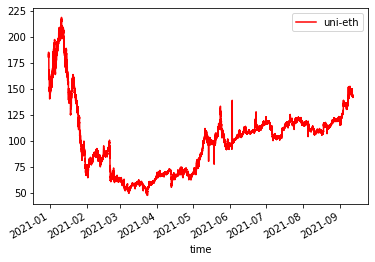

In [142]:
price_chart = pd.DataFrame({'uni-eth': 1/price_data['quotePrice']})
price_chart = price_chart.rename_axis(index={'time_pd':'time'})
price_chart.plot(color='red')

## Return

<AxesSubplot:xlabel='time'>

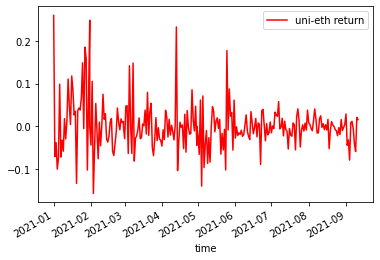

In [156]:
z_score_cutoff                     = 5
STRATEGY_FREQUENCY_MINUTES         = 'D' # evaluate the strategy every minute
simulate_data_filtered             = ActiveStrategyFramework.aggregate_price_data(price_data,STRATEGY_FREQUENCY_MINUTES)
simulate_data_filtered['z_scores'] = np.abs(scipy.stats.zscore(simulate_data_filtered['price_return']))
simulate_data_filtered             = simulate_data_filtered.drop(simulate_data_filtered[simulate_data_filtered.z_scores > z_score_cutoff].index)

price_chart = pd.DataFrame({'uni-eth return': simulate_data_filtered['price_return']})
price_chart = price_chart.rename_axis(index={'time_pd':'time'})
price_chart.plot(color='red')


# Volatility

<AxesSubplot:xlabel='time'>

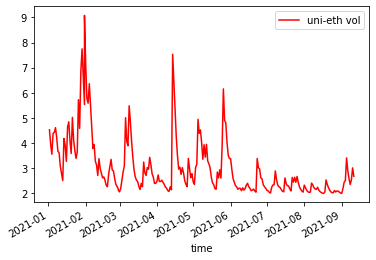

In [157]:
ar_model                 = arch.univariate.ARX(simulate_data_filtered['price_return'], lags=1,rescale=True)
ar_model.volatility      = arch.univariate.GARCH(p=1,q=1)      
res                      = ar_model.fit(update_freq=0, disp="off")

volatility_df            = pd.DataFrame({'uni-eth vol': ((365)**.5)*res.conditional_volatility/(res.scale**.5)})
volatility_df['time']    = simulate_data_filtered.index
volatility_df            = volatility_df.set_index("time")
volatility_df.plot(color='red')

# Simulation

After an optimization process that was conducted to calibrate the relevant parameters, let's look at simulated performance from July 1st to September 10 2021.

In [ ]:
# Select date ranges for strategy simulation
DATE_BEGIN                 = pd.to_datetime('2021-07-01 00:00PM',utc=True)
DATE_END                   = pd.to_datetime('2021-09-10 00:00PM',utc=True)
z_score_cutoff             = 5

# Data for strategy simulation. We can use aggregate_price_data to analyze the strategy at a coarser STRATEGY_FREQUENCY in minutes
STRATEGY_FREQUENCY_MINUTES         = 'M' # evaluate the strategy every minute
simulate_data_filtered             = ActiveStrategyFramework.aggregate_price_data(price_data,STRATEGY_FREQUENCY_MINUTES)
simulate_data_filtered['z_scores'] = np.abs(scipy.stats.zscore(simulate_data_filtered['price_return']))
simulate_data_filtered             = simulate_data_filtered.drop(simulate_data_filtered[simulate_data_filtered.z_scores > z_score_cutoff].index)
simulate_data_price                = simulate_data_filtered[DATE_BEGIN:DATE_END]['quotePrice']

# Data for statistical analaysis (AGGREGATED_MINUTES frequency data)
STAT_MODEL_FREQUENCY                    = 'D'
argarch_model_data_filtered             = ActiveStrategyFramework.aggregate_price_data(price_data,STAT_MODEL_FREQUENCY)
argarch_model_data                      = argarch_model_data_filtered

# USD Data remove outliers
token_0_usd_data_filtered             = ActiveStrategyFramework.aggregate_price_data(token_0_usd_data,STRATEGY_FREQUENCY_MINUTES)
token_0_usd_data_filtered['z_scores'] = np.abs(scipy.stats.zscore(token_0_usd_data_filtered['price_return']))
token_0_usd_data_filtered             = token_0_usd_data_filtered.drop(token_0_usd_data_filtered[token_0_usd_data_filtered.z_scores > z_score_cutoff].index)


# Initial Position Details
initial_usd_price          = 1/token_0_usd_data_filtered.iloc[abs(token_0_usd_data.index - DATE_BEGIN).argmin()]['quotePrice']
INITIAL_TOKEN_0            = 100000/initial_usd_price
INITIAL_TOKEN_1            = INITIAL_TOKEN_0*simulate_data_price[0]
INITIAL_POSITION_VALUE     = 2*INITIAL_TOKEN_0*initial_usd_price
FEE_TIER                   = 0.003

# Set decimals according to your pool
DECIMALS_0 = 18
DECIMALS_1 = 18
swap_data['virtual_liquidity'] = swap_data['VIRTUAL_LIQUIDITY_ADJUSTED']*10**DECIMALS_1
swap_data['traded_in']         = swap_data.apply(lambda x: -x['amount0'] if (x['amount0'] < 0) else -x['amount1'],axis=1).astype(float)
swap_data['traded_out']        = swap_data.apply(lambda x:  x['amount0'] if (x['amount0'] > 0) else  x['amount1'],axis=1).astype(float)

# Strategy Parameters
alpha_range      = [.4]
tau_range        = [.3]
limit_range      = [.5,.75]
vol_range        = [.75,.85]
sim_performance  = []
sim_results      = []

import importlib
importlib.reload(AutoRegressiveStrategy)

for j in list(itertools.product(alpha_range,tau_range,limit_range,vol_range)):
    print(j)
    AR_Strategy                      = AutoRegressiveStrategy.AutoRegressiveStrategy(argarch_model_data,j[0],j[1],j[2],j[3])
    simulated_strategy               = ActiveStrategyFramework.simulate_strategy(simulate_data_price,swap_data,AR_Strategy,INITIAL_TOKEN_0,INITIAL_TOKEN_1,FEE_TIER,DECIMALS_0,DECIMALS_1)
    sim_data                         = ActiveStrategyFramework.generate_simulation_series(simulated_strategy,AR_Strategy)
    strat_result                     = ActiveStrategyFramework.analyze_strategy(sim_data,INITIAL_POSITION_VALUE,token_0_usd_data_filtered)
    strat_result['alpha_param']      = j[0]
    strat_result['tau_param']        = j[1]
    strat_result['limit_param']      = j[2]
    strat_result['volatility_param'] = j[3]
    sim_results.append(simulated_strategy)
    sim_performance.append(strat_result)

In [7]:
pd.DataFrame(sim_performance)

,days_strategy,gross_fee_apr,gross_fee_return,net_apr,net_return,rebalances,max_drawdown,volatility,sharpe_ratio,mean_base_position,median_base_position,alpha_param,tau_param,limit_param,volatility_param
0,71,0.932325,0.181356,15.050526,2.927636,16,0.946137,16.812043,0.895223,0.826419,0.786434,0.4,0.3,0.50,0.75
1,71,1.022576,0.198912,15.031804,2.923995,17,0.946137,16.813300,0.894042,0.746865,0.783546,0.4,0.3,0.50,0.85
2,71,0.929875,0.180880,15.042390,2.926054,15,0.946137,16.812039,0.894739,0.824854,0.786434,0.4,0.3,0.75,0.75
3,71,1.020132,0.198437,15.023686,2.922416,16,0.946137,16.813296,0.893560,0.745302,0.783546,0.4,0.3,0.75,0.85


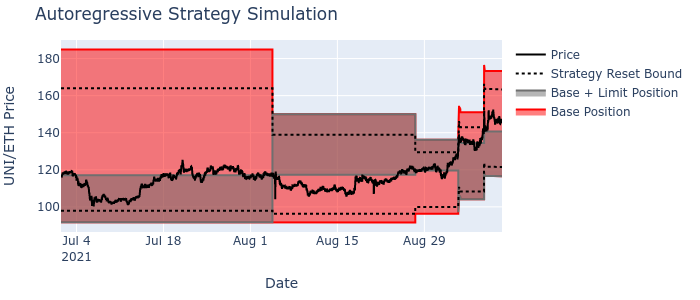

In [8]:
SELECTED_STRATEGY                         = 2
resulting_strat                           = sim_results[SELECTED_STRATEGY]
resulting_data                            = ActiveStrategyFramework.generate_simulation_series(resulting_strat,AR_Strategy)
ActiveStrategyFramework.plot_strategy(resulting_data,'UNI/ETH Price')

In [31]:
resulting_data[resulting_data.reset_point]

,time,price,price_1_0,reset_point,reset_reason,volatility,return_forecast,base_range_lower,base_range_upper,limit_range_lower,...,token_0_allocated,token_1_allocated,token_0_total,token_1_total,value_position,value_allocated,value_left_over,base_position_value,limit_position_value,value_hold
time,,,,,,,,,,,,,,,,,,,,,
2021-08-04 13:00:00+00:00,2021-08-04 13:00:00+00:00,0.008523,117.326171,True,vol_rebalance,0.613064,0.015675,0.006670,0.010915,0.006670,...,16139.147569,137.852787,16139.147569,137.852787,32312.887245,32312.887245,0.000000e+00,32297.609515,15.277730,32312.887245
2021-08-27 13:00:00+00:00,2021-08-27 13:00:00+00:00,0.008359,119.625484,True,vol_rebalance,0.442071,0.029653,0.007341,0.010385,0.007341,...,17401.027930,127.181071,17401.027930,127.181071,32615.125090,32615.125090,0.000000e+00,28285.664358,4329.460732,32629.853909
2021-09-03 11:04:00+00:00,2021-09-03 11:04:00+00:00,0.007679,130.232015,True,exited_range,0.479086,0.066190,0.007160,0.010298,0.007679,...,28336.647693,39.559962,28336.647693,39.559962,33488.621285,33488.621285,9.253541e-13,26901.702936,6586.918349,34091.993889
2021-09-03 11:24:00+00:00,2021-09-03 11:24:00+00:00,0.007525,132.884919,True,exited_range,0.479086,0.066190,0.007017,0.010092,0.007525,...,29774.991987,28.666298,29774.991987,28.666298,33584.310665,33584.310665,0.000000e+00,18540.772652,15043.538013,34457.704043
2021-09-03 11:58:00+00:00,2021-09-03 11:58:00+00:00,0.007399,135.159069,True,exited_range,0.479086,0.066190,0.006899,0.009922,0.007399,...,30749.270423,21.422059,30749.270423,21.422059,33644.655935,33644.655935,0.000000e+00,15104.748763,18539.907172,34771.201968
2021-09-03 13:36:00+00:00,2021-09-03 13:36:00+00:00,0.007272,137.509833,True,exited_range,0.480491,0.044442,0.006473,0.009393,0.007272,...,31556.695090,15.514897,31556.695090,15.514897,33690.145986,33690.145986,0.000000e+00,6803.267888,26886.878099,35095.261378
2021-09-03 13:56:00+00:00,2021-09-03 13:56:00+00:00,0.007297,137.037529,True,limit_imbalance,0.480491,0.044442,0.006495,0.009425,0.007297,...,30775.640573,21.200238,30775.640573,21.200238,33680.868781,33680.868781,0.000000e+00,9248.101878,24432.766904,35030.152914
2021-09-03 15:22:00+00:00,2021-09-03 15:22:00+00:00,0.007334,136.346360,True,limit_imbalance,0.480491,0.044442,0.006528,0.009473,0.007334,...,30013.917807,26.778228,30013.917807,26.778228,33665.031705,33665.031705,0.000000e+00,11062.656245,22602.375460,34934.873352
2021-09-03 17:20:00+00:00,2021-09-03 17:20:00+00:00,0.007368,135.720603,True,limit_imbalance,0.480491,0.044442,0.006558,0.009517,0.007368,...,29254.887480,32.373279,29254.887480,32.373279,33648.608380,33648.608380,9.643529e-13,13300.236042,20348.372338,34848.610984


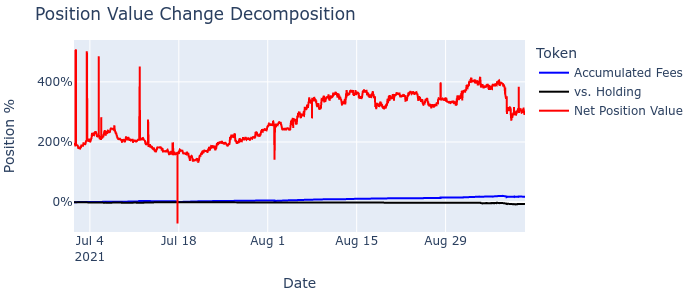

In [29]:
resulting_data_graph = resulting_data.join(token_0_usd_data_filtered.price_0_usd,how='inner')

resulting_data_graph['cum_fees_usd']        = resulting_data_graph.price_0_usd*(resulting_data_graph['token_0_fees'].cumsum() + (resulting_data_graph['token_1_fees'] * resulting_data_graph['price_1_0']).cumsum())
resulting_data_graph['value_hold']          = resulting_data_graph.price_0_usd*(INITIAL_TOKEN_0 + INITIAL_TOKEN_1 * resulting_data_graph['price_1_0'])
resulting_data_graph['relative_to_holding'] = (resulting_data_graph.price_0_usd*resulting_data_graph['value_position'])/resulting_data_graph['value_hold']-1
resulting_data_graph['net_gain']            = (resulting_data_graph.price_0_usd*resulting_data_graph['value_position']  - INITIAL_POSITION_VALUE)/INITIAL_POSITION_VALUE


fig_income = go.Figure()
fig_income.add_trace(go.Scatter(
    x=resulting_data_graph['time'], 
    y=resulting_data_graph['cum_fees_usd']/INITIAL_POSITION_VALUE,
    fill=None,
    mode='lines',
    line_color='blue',
    name='Accumulated Fees',
    ))

fig_income.add_trace(go.Scatter(
    x=resulting_data_graph['time'], 
    y=resulting_data_graph['relative_to_holding'],
    fill=None,
    mode='lines',
    line_color='black',
    name='vs. Holding',
    ))

fig_income.add_trace(go.Scatter(
    x=resulting_data_graph['time'], 
    y=resulting_data_graph['net_gain'],
    fill=None,
    mode='lines',
    line_color='#ff0000',
    name='Net Position Value'
    ))

fig_income.update_layout(
    margin=dict(l=20, r=20, t=40, b=20),
    height= CHART_SIZE,
    title = 'Position Value Change Decomposition',
    xaxis_title="Date",
    yaxis_title="Position %",
    legend_title='Token',
    yaxis=dict(tickformat = "%"),
)

fig_income.show(renderer="png")


2021-07-01 12:00:00+00:00    1775.039782
2021-07-01 12:01:00+00:00    1774.906766
2021-07-01 12:02:00+00:00    1764.978918
2021-07-01 12:03:00+00:00    1764.978918
2021-07-01 12:04:00+00:00    1767.268827
                                ...     
2021-09-10 11:56:00+00:00    1470.550637
2021-09-10 11:57:00+00:00    1470.911065
2021-09-10 11:58:00+00:00    1470.910930
2021-09-10 11:59:00+00:00    1470.910930
2021-09-10 12:00:00+00:00    1470.910930
Length: 102867, dtype: float64

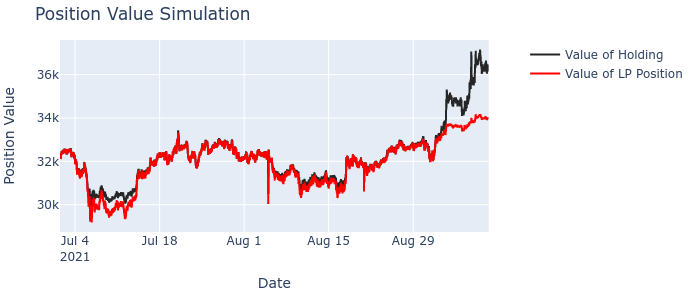

In [14]:
# 4 - Performance Comparison


CHART_SIZE = 300
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from plotly.subplots import make_subplots
fig_performance = make_subplots(specs=[[{"secondary_y": True}]])
fig_performance.add_trace(go.Scatter(
    x=resulting_data['time'], 
    y=resulting_data['value_hold'],
    name='Value of Holding',
    fill=None,
    mode='lines',
    line_color='#262626',
    ),secondary_y=False,)

fig_performance.add_trace(go.Scatter(
    x=resulting_data['time'], 
    y=resulting_data['value_position'],
    name='Value of LP Position',
    fill=None,
    mode='lines',
    line_color='#ff0000',    
    ),secondary_y=False,)

fig_performance.update_layout(
    margin=dict(l=20, r=20, t=40, b=20),
    height= CHART_SIZE,
    title = 'Position Value Simulation',
    xaxis_title="Date",
    yaxis_title="Position Value",
)
fig_performance.show(renderer="png")

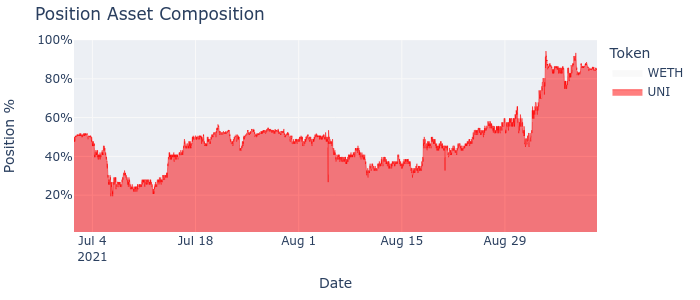

In [16]:
# 3 - Asset Composition
fig_composition = go.Figure()
fig_composition.add_trace(go.Scatter(
    x=resulting_data['time'], y=resulting_data['token_0_total'],
    mode='lines',
    name=price_data['baseCurrency'][0],
    line=dict(width=0.5, color='#ff0000'),
    stackgroup='one', # define stack group
    groupnorm='percent'
))
fig_composition.add_trace(go.Scatter(
    x=resulting_data['time'], y=resulting_data['token_1_total']*resulting_data['price_1_0'],
    mode='lines',
    name=price_data['quoteCurrency'][0],
    line=dict(width=0.5, color='#f4f4f4'),
    stackgroup='one'
))

fig_composition.update_layout(
    showlegend=True,
    xaxis_type='date',
    yaxis=dict(
        type='linear',
        range=[1, 100],
        ticksuffix='%'))

fig_composition.update_layout(
    margin=dict(l=20, r=20, t=40, b=20),
    height= CHART_SIZE,
    title = 'Position Asset Composition',
    xaxis_title="Date",
    yaxis_title="Position %",
    legend_title='Token'
)

fig_composition.show(renderer="png")